# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

In [136]:
import numpy as np
import pandas as pd
import pandera as pa
from typing import Type, Optional
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta
import datetime

from sklearn.preprocessing import MinMaxScaler

In [7]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [8]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [9]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [10]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [11]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [12]:
# timeseries data breakout
df["DAY_NAME"] = df["DATETIME"].dt.day_name()
df["MONTH"] = df["DATETIME"].dt.month
df["YEAR"] = df["DATETIME"].dt.year
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [13]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,DAY_NAME,MONTH,YEAR,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [14]:
import meteostat as met

In [15]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [16]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [17]:
combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [18]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

mean_wdat = pd.concat([mean_wdat, sun_data], axis=1)[:-1]

In [19]:
mean_wdat.head()

,tavg,wspd,sun_eff
2011-01-01,5.300,14.400,0.018301
2011-02-01,7.500,18.000,0.026512
2011-03-01,8.925,15.775,0.068665
2011-04-01,13.100,13.550,0.117791
2011-05-01,13.580,14.300,0.125091


Since I have to break this dataset into training, validation, and testing sets, I skip 2020 because I cannot train on it without the risk of overfitting at this timeframe (monthly/LTLF) and the data is anomalous. Perhaps in a later iteration I might add a dummy to the input layer that checks for 2020, but at this time we will keep things simple.

In [138]:
full_data = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(full_data)

# agg_full = full_data[full_data.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

agg_full = full_data[full_data.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
scaled_train = scaler.fit_transform(agg_full[agg_full.index < pd.to_datetime("2017-01-01")])
scaled_val = scaler.fit_transform(agg_full[(agg_full.index >= pd.to_datetime("2017-01-01")) & (agg_full.index < pd.to_datetime("2020-01-01"))])
scaled_test = scaler.fit_transform(agg_full[(agg_full.index >= pd.to_datetime("2020-01-01")) & (agg_full.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [252]:
def df_to_X_y(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-seasonal_order):
    row = [a for a in df_as_np[i:i+seasonal_order]]
    X.append(row)
    label = df_as_np[i+seasonal_order][0]
    y.append(label)
  return np.array(X), np.array(y).reshape(-1,1)

In [396]:
SEASONAL_ORDER = 11

In [397]:
X_train, y_train = df_to_X_y(scaled_train, SEASONAL_ORDER)

In [398]:
X_train[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [399]:
y_train[0]

array([0.82318279])

In [400]:
X_val, y_val = df_to_X_y(scaled_val, SEASONAL_ORDER)
X_test, y_test = df_to_X_y(scaled_test, SEASONAL_ORDER)

### Running the LTLF

In [401]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error

In [402]:

ltlf_model = Sequential()
ltlf_model.add(InputLayer((SEASONAL_ORDER, 1)))
ltlf_model.add(LSTM(128, return_sequences=True))
ltlf_model.add(LSTM(128))
ltlf_model.add(Dense(8, 'relu'))
ltlf_model.add(Dense(1, 'linear'))

ltlf_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_55 (LSTM)                  │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [403]:
cp = ModelCheckpoint('ltlf_model.keras', save_best_only=True)
ltlf_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [404]:
ltlf_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 0.2150 - root_mean_squared_error: 0.4630 - val_loss: 0.1573 - val_root_mean_squared_error: 0.3966
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0978 - root_mean_squared_error: 0.3120 - val_loss: 0.1350 - val_root_mean_squared_error: 0.3674
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0848 - root_mean_squared_error: 0.2910 - val_loss: 0.1247 - val_root_mean_squared_error: 0.3532
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543 - val_loss: 0.1177 - val_root_mean_squared_error: 0.3430
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0674 - root_mean_squared_error: 0.2594 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3509
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0755 - root_mean_squared_error: 0.2745 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3415
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0685 - roo

In [405]:
from tensorflow.keras.models import load_model
ltlf_model = load_model('ltlf_model.keras')

In [406]:
predictions = ltlf_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test = scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


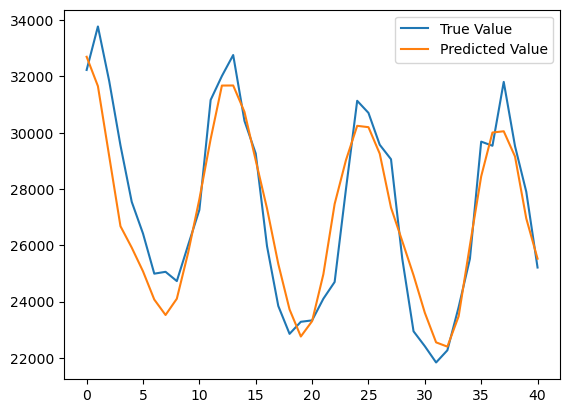

In [407]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='True Value')
plt.plot(predictions, label='Predicted Value')
plt.legend()
plt.show()

In [408]:
print(f"MAPE: {mean_absolute_percentage_error(y_test, predictions)*100:.3f}%")

MAPE: 3.675%
